# Regression, GLMs, and Bayesian vs Frequentist perspectives

## Setup and imports

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import pymc as pm
import bambi as bmb
import arviz as az
import statsmodels.api as sm

In this notebook, we'll be working with a dataset containing information on wind turbines.

In [2]:
turbines = pd.read_csv('turbines.csv')
# The "year" column contains how many years since the year 2000
turbines['year'] = turbines['p_year'] - 2000
turbines = turbines.drop('p_year', axis=1)

turbines.head()

,t_state,t_built,t_cap,year
0,AK,6,390.0,-3.0
1,AK,6,475.0,-1.0
2,AK,2,100.0,0.0
3,AK,1,1500.0,1.0
4,AK,1,100.0,2.0


In [3]:
ok_turbines.plot?

Object `ok_turbines.plot` not found.


<Figure size 640x480 with 0 Axes>

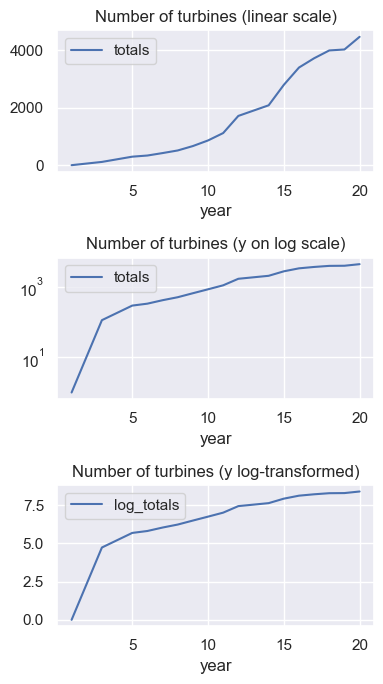

In [4]:
# Turbines in Oklahoma from 2000 on
ok_filter = (turbines.t_state == 'OK')
ok_turbines = turbines[ok_filter].sort_values('year')

ok_turbines = ok_turbines[ok_turbines['year'] > 0]
ok_turbines["totals"] = np.cumsum(ok_turbines["t_built"])
# Log-transform the counts, too
ok_turbines["log_totals"] = np.log(ok_turbines["totals"])

plt.figure()

f, (ax_top, ax_mid, ax_bot) = plt.subplots(3, 1, figsize=(4, 7))
ok_turbines.plot('year', 'totals', ax=ax_top)
ax_top.set_title('Number of turbines (linear scale)')


ok_turbines.plot('year', 'totals', ax=ax_mid)
ax_mid.semilogy();
ax_mid.set_title('Number of turbines (y on log scale)')
ok_turbines.plot('year', 'log_totals', ax=ax_bot)
ax_bot.set_title('Number of turbines (y log-transformed)')
plt.tight_layout()

### Bayesian model: fitting a GLM with Bambi

In [5]:
# bmb.Model tells us we're creating a GLM
# `log_totals ~ year` is how we tell Bambi that log_totals is our y column and year is our only x column
gaussian_model = bmb.Model(formula='log_totals ~ year', data=ok_turbines)
gaussian_trace = gaussian_model.fit(random_seed=0)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, year]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [35]:
gaussian_trace

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

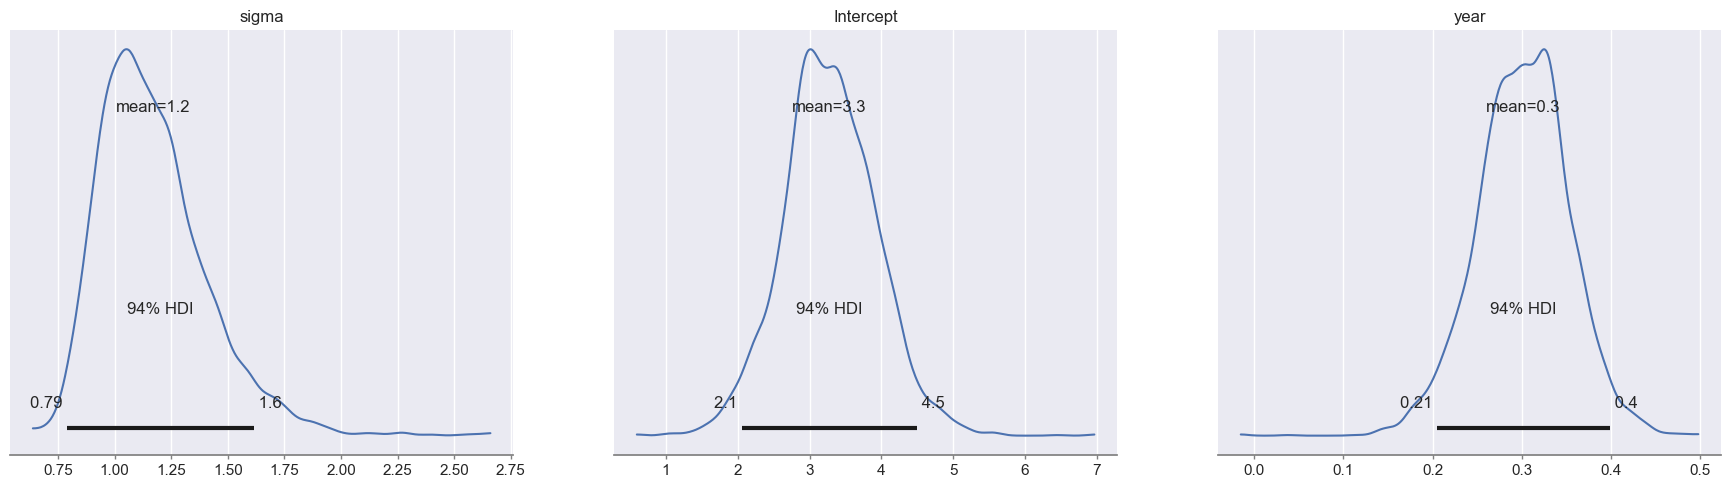

In [6]:
# plot_posterior is a great way to visualize the posterior distributions from a trace object
az.plot_posterior(gaussian_trace);

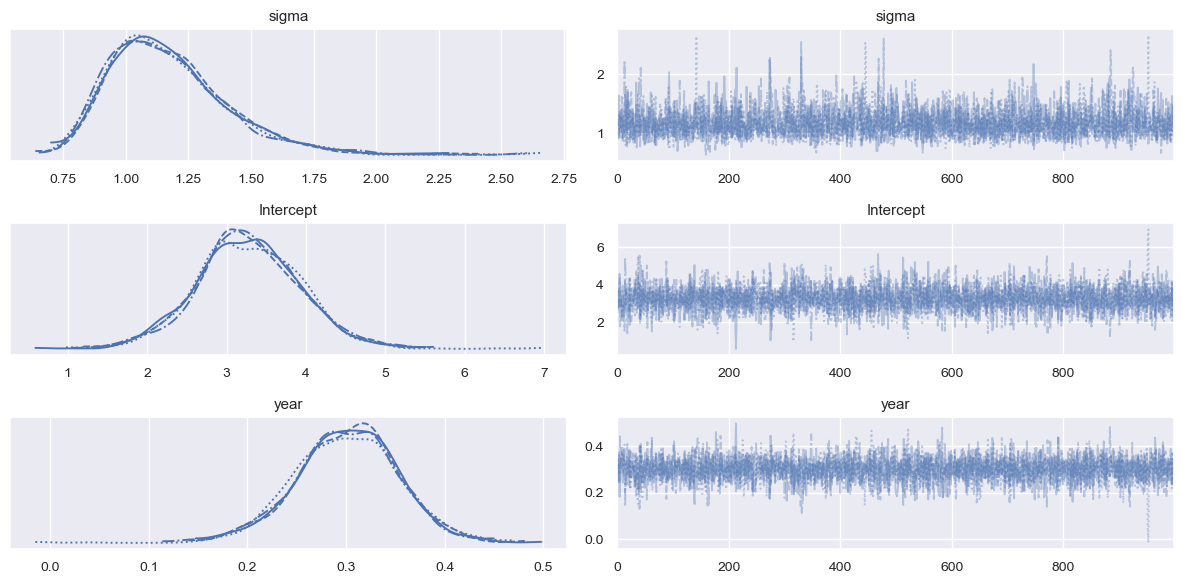

In [7]:
# plot_trace visualizes the samples from each chain separately: 
# the extra info can be helpful in debugging
az.plot_trace(gaussian_trace)
plt.tight_layout()

The mean of the coefficient for `year` is around 0.3. What does this mean? It means that for every unit increase in `year` (i.e., every year), we see a linear increase of about 0.3 in `log_totals`. But we're not really interested in `log_totals`!

We're really interested in how `year` affects the turbine count (rather than the log). Let $N_{t}$ be the number of turbines in year $t$, and let $y_t = \log(N_t)$ be what we're predicting in the regression above. Then we have:

$$
y_{t+1} = y_t + 0.3 \\
\log(N_{t+1}) = \log(N_t) + 0.3 \\
N_{t+1} = N_t e^{0.3}
$$

In other words, every year, this regression tells us that the prediction is $e^{0.3}$ times the value from the previous year. That's the effect that log-transforming the data has on the output: instead of predicting an additive increase, we're predicting a multiplicative increase.

In [8]:
np.exp(0.3)

1.3498588075760032

That's an increase of about $35\%$ every year.

In [9]:
# From the graph above, it looks like the coefficient could 
# reasonably be between 0.25 and 0.35. How does that affect
# the year-over-year change?
(np.exp(0.25), np.exp(0.35))

(1.2840254166877414, 1.4190675485932571)

### Visualizing samples from the posterior

$$
\mathrm{Posterior:}\,p(\beta_0, \beta_1 \mid y_1, \ldots, y_n, x_1, \ldots, x_n)
$$

In [10]:
# The posterior is the conditional density over β given obs. data:
# i.e., a distribution over the slope and intercept. 
# So, each sample from the posterior represents one slope and one intercept value:
# i.e., a prediction line! 
# This code visualizes 
def plot_posterior_samples(trace, turbines_df, num_lines=40):
    f, ax = plt.subplots(1, 1)
    intercept = trace.posterior['Intercept'].values.flatten()
    slope = trace.posterior['year'].values.flatten()
    indices = np.random.choice(np.arange(slope.size), num_lines, replace=False)
    for i in indices:
        pred = intercept[i] + slope[i] * turbines_df['year'] 
        ax.plot(turbines_df['year'], pred, color='gray', alpha=0.3)

    
    ax.scatter(turbines_df['year'], turbines_df['log_totals'])
    ax.set_xlabel('Years since 2000')
    ax.set_ylabel('log(turbine count)')



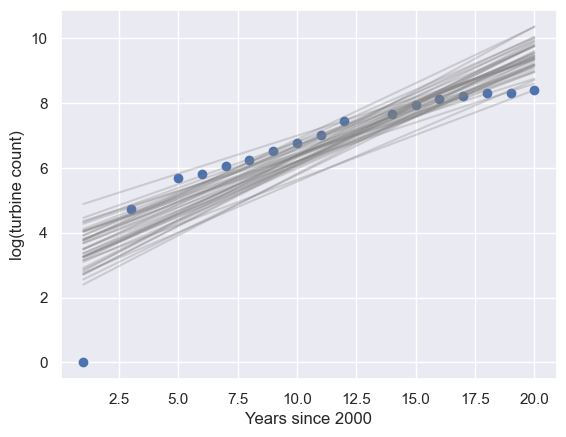

In [11]:
plot_posterior_samples(gaussian_trace, ok_turbines)

## Count regression

### Poisson regression

What about the [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution)?
* One *positive* parameter $\lambda$ 
* $\lambda$ represents the mean (and variance, too).


New likelihood model
$$
y_i | \beta \sim \text{Poisson}(\exp(x_i \,\cdot \,\beta))
$$


In [12]:
poisson_model = bmb.Model(formula='totals ~ year', data=ok_turbines, family='poisson')
poisson_trace = poisson_model.fit(random_seed=0)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, year]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


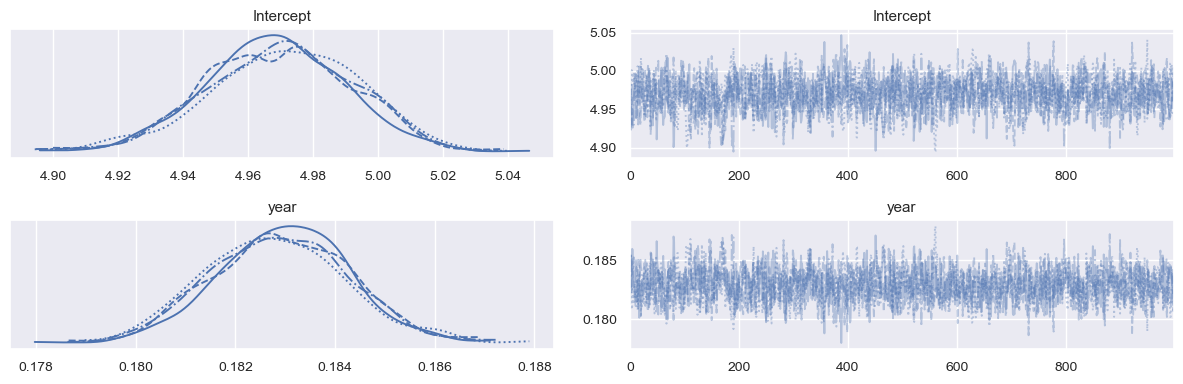

In [13]:
az.plot_trace(poisson_trace)
plt.tight_layout()

What differences do you see between this and the results from before?

In [14]:
# Interpreting the results: 
np.exp(0.183)

1.2008144080808307

* This corresponds to only a $20\%$ average annual growth rate (compared to our $35\%$ average annual growth rate from the earlier model). 
* Is this better? worse?

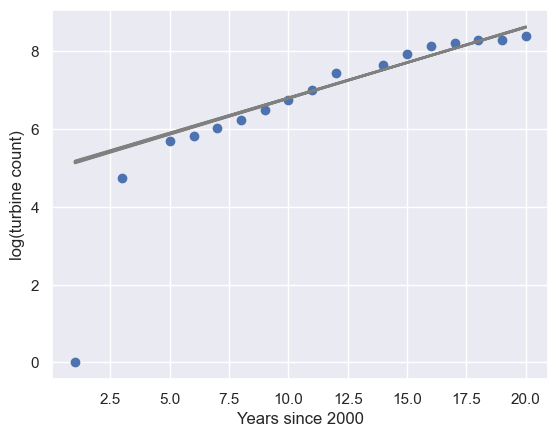

In [15]:
plot_posterior_samples(poisson_trace, ok_turbines)

Why is the model overconfident?

### Negative binomial regression

The [negative binomial distribution](https://en.wikipedia.org/wiki/Negative_binomial_distribution) is also a distribution over counts, but it's more sophisticated than the Poisson distribution. We can think of it one of two ways:
* It's the sum of $r$ [Geometric random variables], each with parameter $p$ (success probability).
* It's like a Poisson distribution if the mean parameter ($\lambda$ above) were also random.

With negative binomial regression, our (inverse) link function is exactly the same, but our likelihood is now:

$$
y_i | \beta \sim \text{NegativeBinomial}(\mu=\exp(x_i \,\cdot \,\beta), \ldots)
$$

In [16]:
negbin_model = bmb.Model(formula='totals ~ year', data=ok_turbines, family='negativebinomial')
negbin_trace = negbin_model.fit(random_seed=0)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, Intercept, year]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [17]:
negbin_trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

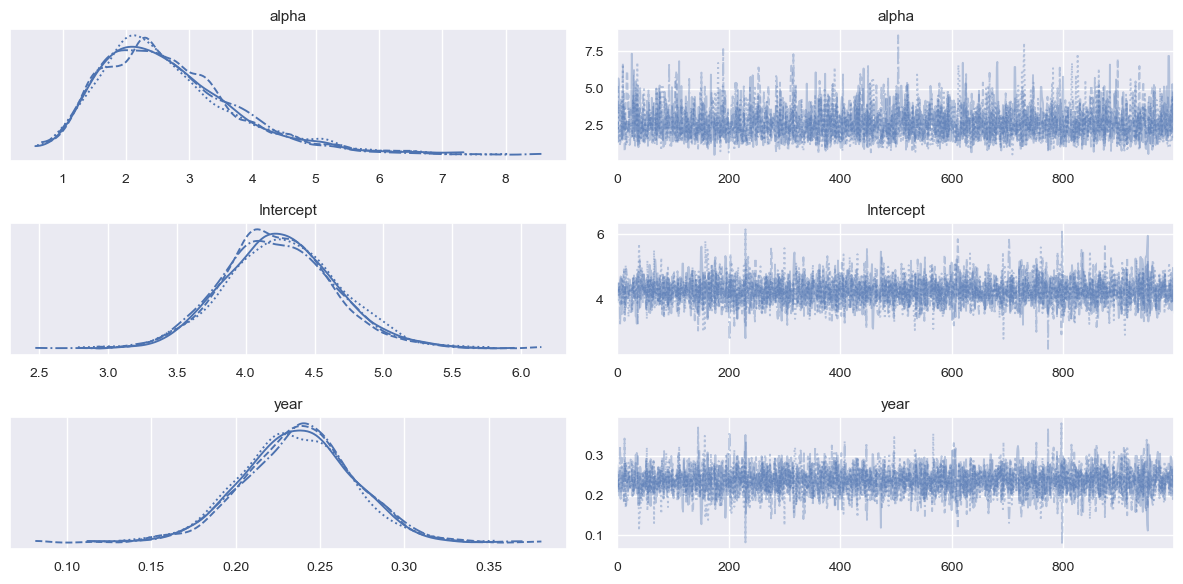

In [18]:
az.plot_trace(negbin_trace)
plt.tight_layout()

Here, the posterior distribution for the $x$ coefficient has a wider spread again. It looks like the mean is around $0.24$:

In [19]:
np.exp(0.24)

1.2712491503214047

This corresponds to a growth rate around $27\%$.

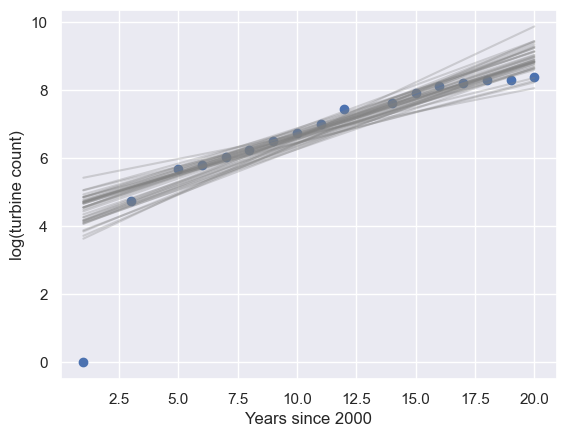

In [20]:
plot_posterior_samples(negbin_trace, ok_turbines)

### Adding a predictor

Suppose we were instead interested in predicting capacity each year based on the number of turbines built:

In [21]:
negbin_cap_model = bmb.Model(formula='t_cap ~ year + t_built', data=ok_turbines, family='negativebinomial')
negbin_cap_trace = negbin_cap_model.fit(random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, Intercept, year, t_built]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


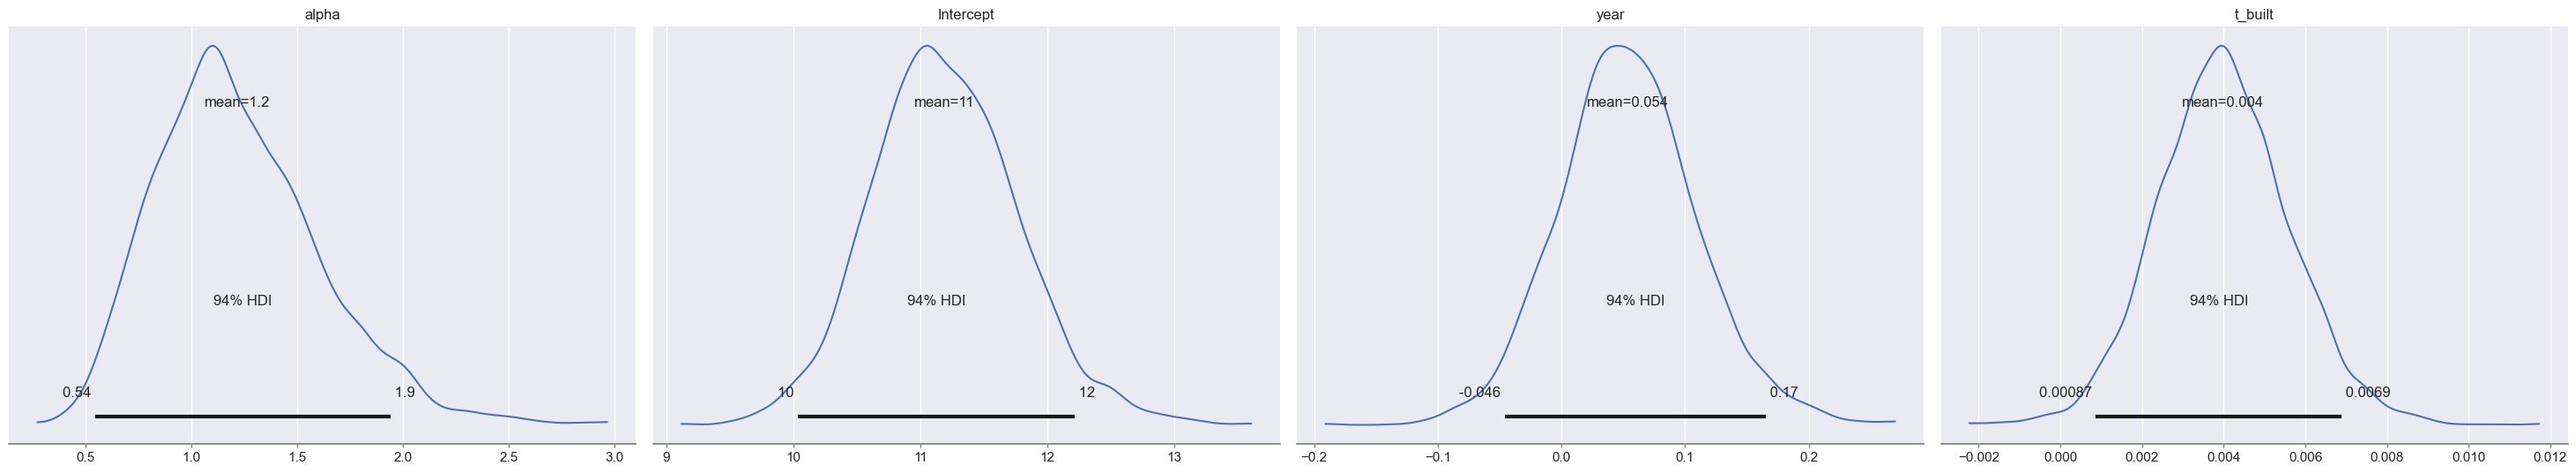

In [22]:
az.plot_posterior(negbin_cap_trace)
plt.tight_layout()

## Generalized Linear Models

By now, you've seen four different versions of regression in the Bayesian setting:

* Linear regression, for predicting real-valued outputs
* Logistic regression, for predicting binary outputs (classification)
* Poisson regression, for predicting counts
* Negative binomial regression, for predicting counts

Let's review what they had in common and what was different between them:

1. For all four, computing our prediction for $y_i$ begins with computing $x_i^T \beta$. This part is a *linear* function of $x_i$, even if we do something nonlinear with it later.
   
2. Each one had a different function that we used to compute the average value of $y_i$ from $x_i^T \beta$. Since this function links the linearly transformed input $x$ to the output $y$, you might expect us to call it the **link function**: this would make a lot of sense. However, the convention is to do the opposite, and call it the **inverse link function**. As you might expect from this name, the **link function** is the inverse of the inverse link function.

3. For each one, we used a different distribution for the likelihood. In all cases, the output of the function above was always the mean of this distribution.

The following table summarizes the different choices of likelihood and link function for the four versions that we've seen:

| Regression | Inverse link function | Link function | Likelihood |
| :-- | :-- | :-- | :-- |
| Linear | identity | identity | Gaussian |
| Logistic | sigmoid | [logit](https://en.wikipedia.org/wiki/Logit) | Bernoulli |
| Poisson | exponential | log | Poisson |
| Negative binomial | exponential | log | Negative binomial |
   
These ideas form the basis for what are known as Generalized Linear Models, or GLMs. Once we choose a link function and a likelihood distribution, our model is fully specified, and we can approximate the posterior distribution over the coefficients in $\beta$.

## Posterior predictive checks

In [23]:
def show_posterior_predictive(model, trace, turbines_df, is_log_y=False, num_lines=40, ax=None):
    if ax is None:
        f, ax = plt.subplots(1, 1)
    # Adds posterior predictive samples to the trace
    model.predict(trace, kind='response')

    y_name = model.response_component.response.name
    pred_arr = trace.posterior_predictive[y_name].values.reshape(-1, 17)
    if is_log_y:
        pred_arr = np.exp(pred_arr)
    for i in range(num_lines):
        ax.plot(ok_turbines['year'], pred_arr[i], alpha=0.1, color='green')
    
    ax.scatter(ok_turbines['year'], ok_turbines['totals'])
    ax.set_ylim([0, 30000])

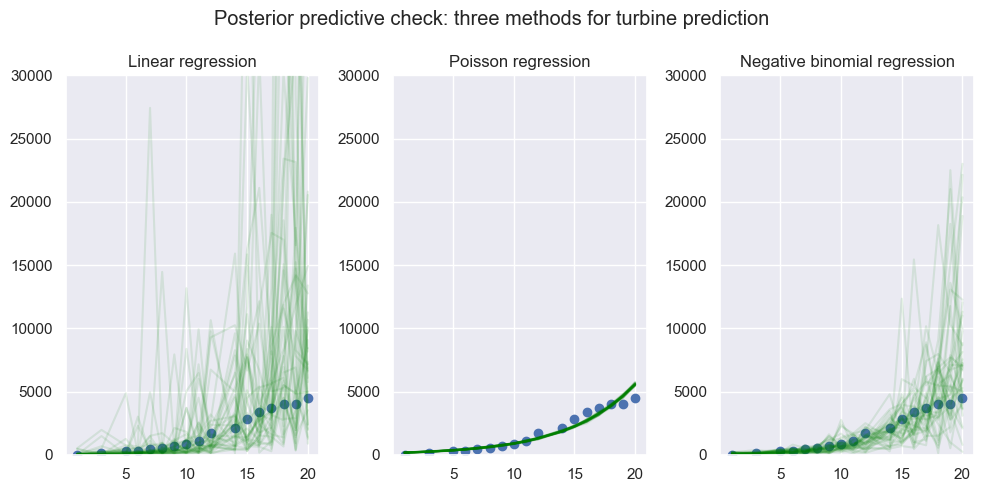

In [24]:
f, axes = plt.subplots(1, 3, figsize=(10, 5))
show_posterior_predictive(gaussian_model, gaussian_trace, ok_turbines, is_log_y=True, ax=axes[0])
axes[0].set_title('Linear regression')

show_posterior_predictive(poisson_model, poisson_trace, ok_turbines, is_log_y=False, ax=axes[1])
axes[1].set_title('Poisson regression')

show_posterior_predictive(negbin_model, negbin_trace, ok_turbines, is_log_y=False, ax=axes[2])
axes[2].set_title('Negative binomial regression')

f.suptitle('Posterior predictive check: three methods for turbine prediction')
plt.tight_layout()

### Frequentist GLMs

We'll look at the same models we implemented before, but this time we'll use the `statsmodels` package to look at things through a frequentist lens.

In [26]:
# Note that we need to use sm.add_constant() if we want an intercept!
gaussian_model_intercept = sm.GLM(
    np.log(ok_turbines.totals), sm.add_constant(ok_turbines.year),
    family=sm.families.Gaussian()
)
gaussian_results = gaussian_model_intercept.fit()
print(gaussian_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 totals   No. Observations:                   17
Model:                            GLM   Df Residuals:                       15
Model Family:                Gaussian   Df Model:                            1
Link Function:               Identity   Scale:                          1.1810
Method:                          IRLS   Log-Likelihood:                -24.472
Date:                Wed, 08 Oct 2025   Deviance:                       17.716
Time:                        21:40:41   Pearson chi2:                     17.7
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9131
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.2602      0.590      5.526      0.0

Take a minute to look over the results. What does it mean that the standard error for the estimated `year` coefficient is 0.047?

In [27]:
poisson_model_freq = sm.GLM(
    ok_turbines.totals, sm.add_constant(ok_turbines.year),
    family=sm.families.Poisson()
)
poisson_results = poisson_model_freq.fit()
print(poisson_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 totals   No. Observations:                   17
Model:                            GLM   Df Residuals:                       15
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -755.42
Date:                Wed, 08 Oct 2025   Deviance:                       1366.3
Time:                        21:40:41   Pearson chi2:                 1.20e+03
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.9697      0.023    219.386      0.0

The coefficients on `p_year` looks similar to what we got with the Bayesian approach. Notice that the standard error is extremely small: we have the same problem with overconfidence!

Note that in addition to the coefficients at the bottom, we also get goodness of fit measures such as log-likelihood, deviance, and chi-squared: we'll talk a little more about these and what they mean later.

For now, let's try the negative binomial model:

In [28]:
negbin_model_freq = sm.GLM(
    ok_turbines.totals, sm.add_constant(ok_turbines.year),
    family=sm.families.NegativeBinomial()
)
negbin_results = negbin_model_freq.fit()
print(negbin_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 totals   No. Observations:                   17
Model:                            GLM   Df Residuals:                       15
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -134.14
Date:                Wed, 08 Oct 2025   Deviance:                       7.1483
Time:                        21:40:41   Pearson chi2:                     1.90
No. Iterations:                    11   Pseudo R-squ. (CS):             0.6999
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.2059      0.544      7.725      0.0

/Users/ramesh/anaconda3/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


## Frequentist regression with multiple predictors

In [29]:
adult = pd.read_csv('adult.csv')
adult

,Unnamed: 0,index,Age,Post HS?,Ever Married?,Gender,Hours per Week,50K?
0,0,38,51,1,1,Male,40,1
1,1,23,20,0,0,Female,30,0
2,2,22,58,1,1,Female,40,0
3,3,77,23,1,0,Female,35,0
4,4,80,27,0,0,Male,1,0
...,...,...,...,...,...,...,...,...
85,85,85,50,1,1,Male,80,1
86,86,85,50,1,1,Male,80,1
87,87,5,28,0,1,Male,40,0
88,88,28,60,0,1,Male,40,0


In [30]:
simple_model = sm.GLM(
    adult['50K?'], sm.add_constant(adult['Age']),
    family=sm.families.Binomial()
)
simple_results = simple_model.fit()
print(simple_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   50K?   No. Observations:                   90
Model:                            GLM   Df Residuals:                       88
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -43.093
Date:                Wed, 08 Oct 2025   Deviance:                       86.187
Time:                        21:40:41   Pearson chi2:                     81.5
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1640
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.4015      1.014     -4.342      0.0

In [31]:
complex_model = sm.GLM(
    adult['50K?'], sm.add_constant(adult[['Age', 'Post HS?']]),
    family=sm.families.Binomial()
)
complex_results = complex_model.fit()
print(complex_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   50K?   No. Observations:                   90
Model:                            GLM   Df Residuals:                       87
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -42.636
Date:                Wed, 08 Oct 2025   Deviance:                       85.272
Time:                        21:40:41   Pearson chi2:                     78.4
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1724
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.8221      1.152     -4.187      0.0

In [32]:
complex_model = sm.GLM(
    adult['50K?'], sm.add_constant(adult[['Age', 'Post HS?', 'Hours per Week', 'Ever Married?']]),
    family=sm.families.Binomial()
)
complex_results = complex_model.fit()
print(complex_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   50K?   No. Observations:                   90
Model:                            GLM   Df Residuals:                       85
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -39.151
Date:                Wed, 08 Oct 2025   Deviance:                       78.302
Time:                        21:40:41   Pearson chi2:                     73.5
No. Iterations:                     6   Pseudo R-squ. (CS):             0.2341
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -6.1044      1.853     -3.

Compare the three models above using the tools we've learned.

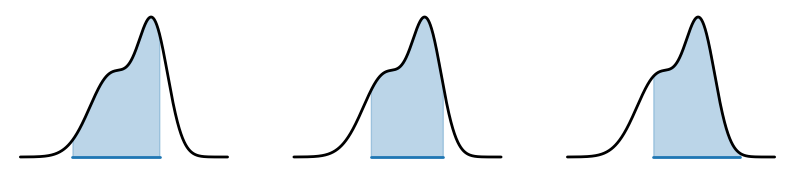